## Smart campaign - Relative strength

Campaign composition is based on: https://10.0.1.2:8888/notebooks/Money%20Management%20Alphas/Campaign_Bidirectional_6C_6E_6B_ContFut_DSP%2Bfor%2Bproduction_Oct17_w_enhancement_V3.ipynb

    

In this campaign we are going to implement:
- Relative strength alpha picking
- Alpha tagging (calculation of RelStr based on long and short tagged alphas)


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
CAMPAIGN_DICT = {
    'name': "SmartCampaign_RelStr_Concept",
    
    # Allowed values for both ALPHA_RISK_TYPE and CAMPAIGN_RISK_TYPE

    # 'atr' - ATR(RISK_PERIOD) of alpha/campaign equity risk metric
    # 'atrmax' - Highest(ATR(RISK_PERIOD)) of alpha/campaign equity risk metric
    # 'ddavg' - rolling mean (RISK_PERIOD) of drawdown of alpha/campaign equity 
    # 'ddmax' - rolling maximum (RISK_PERIOD) of drawdown of alpha/campaign equity
    # 'ddq95' - rolling 95% quantile (RISK_PERIOD) of drawdown of alpha/campaign equity        
    'alpha_risk_type': 'atr',
    'alpha_risk_period': 100,
    'alpha_min_risk': 100,

    'campaign_risk_type': 'atrmax',
    'campaign_risk_period': 100,
    'campaign_min_risk': 100,
    
    'relstr_mean_period': 100,
    
    #
    # Campaign definition
    #
    'alphas': {
    
        # BULLISH
        # Single alphas
        '!NEW_AlphaV1Exposure_HedgedBy_V2_US_6C_EXO_PutSpread_DynKel_longs_LP_DSP_LPBP_Combination__Bullish_Sept_15_Oct_13': {'tag': 'long'},
        '!NEW_AlphaV1Exposure_HedgedBy_V2_US_6C_EXO_CallSpread_DynKel_shorts_LP_DSP_LowPass__Bullish_Sept_15_Oct_13': {'tag': 'long'},
        '!NEW_AlphaV1Exposure_HedgedBy_V2_US_6C_EXO_PutSpread_DynKel_longs_LP_DSP_BandPass__Bullish_Sept_15_Oct_17': {'tag': 'long'},
        '!NEW_AlphaV1Exposure_HedgedBy_V2_US_6C_EXO_CallSpread_DynKel_shorts_LP_DSP_BandPass__Bullish_Sept_15_Oct_17': {'tag': 'long'},
        
        # !! Risk reversal stack V1 + V2
        '6C_ContFut_Long_Strategy_DSP_LPBP_Combination__Bullish_Sept_15__hedged': {
            'tag': 'long',  # <- tagging!
            'alphas': {
                '6C_ContFut_Long_Strategy_DSP_LPBP_Combination__Bullish_Sept_15_custom': 1.0,
                '!NEW_AlphaV1Exposure_HedgedBy_V2_US_6C_EXOSemiFuture_DynKel_20_80_longs_DSP_LPBP_Combination__Bullish_Sept_15_Oct_17' :1.0,  
            }
        },
    
        # BEARISH
        '!NEW_AlphaV1Exposure_HedgedBy_V2_US_6C_EXO_CallSpread_DynKel_shorts_1_DSP_LowPass__Bearish_Sept_15_Oct_13': {'tag': 'short'},
        '!NEW_AlphaV1Exposure_HedgedBy_V2_US_6C_EXO_CallSpread_DynKel_shorts_1_DSP_LPBP_Combination__Bearish_Sept_15_Oct_13': {'tag': 'short'},
        '!NEW_AlphaV1Exposure_HedgedBy_V2_US_6C_EXO_CallSpread_DynKel_shorts_1_DSP_LowPass__Bearish_2_Sept_15_Oct_13': {'tag': 'short'},
    }
}

### Loading smart campaign alphas

In [4]:
import pandas as pd
from smartcampaign import SmartCampaignBase
from smartcampaign.tools import *
import os

#
# Init V1 framework datasource
#
from exobuilder.data.exostorage import EXOStorage
from scripts.settings import *

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)



# Loading V1 and V2 alphas
alphas_list = SmartCampaignBase.get_alphas_list_from_settings(CAMPAIGN_DICT)
alphas_series_dict = storage.swarms_data(alphas_list, load_v2_alphas=True)
df_alphas_equities = pd.DataFrame({k: v['swarm_series']['equity'] for k,v in alphas_series_dict.items()})


## Creating customized SmartCampaign

There are 3 main methods for SmartCampaign customization
- calc_alpha_risk(...) - calculates the risk of a particucular alpha equity in dollars
- compose_portfolio(...) - allows you to manage portfolio of alphas, by shutting down or managing alpha weights
- calc_campaign_risk(...) - calculates custom campaign risk 

In [5]:
class SmartCampaignCustom(SmartCampaignBase):    
    def calc_alpha_risk(self, alpha_equity):
        """
        Perform calculation of single alpha risk
        :param alpha_equity: alpha equity series
        :return: risk adjusted alpha equity series
        """
        # Note: CAMPAIGN_DICT values are available via self._cmp_dict
        
        # Use default method of SmartCampaignBase.calc_alpha_risk()
        return super().calc_alpha_risk(alpha_equity)
        
    def compose_portfolio(self, df_adj_alpha_equity: pd.DataFrame) -> dict:
        """
        Main portfolio composition method (by default it returns all alphas with weight 1.0)
        :param df_adj_alpha_equity: Risk adjusted equity dataframe
        :return: dict[alpha_name: adj_alpha_size]                
        """
        # Note: CAMPAIGN_DICT values are available via self._cmp_dict
        result_dict = {}
        
        
        # Calculating relative strength to average LONG-tagged set of equities
        relstr_mean_per = self._cmp_dict['relstr_mean_period']
        
        eq_long = df_adj_alpha_equity[self.tags['long']].ffill()
        
        if len(eq_long):
            # Calculate all equities index
            eq_chg = eq_long.diff(relstr_mean_per)
            eq_mean = eq_chg.mean(axis=1)

            # Select alphas which are relatively greater than average
            for alpha_name in eq_chg:
                if eq_chg[alpha_name][-1] >= eq_mean[-1]:
                    result_dict[alpha_name] = 1.0
                else:
                    result_dict[alpha_name] = 0.0
                
                
        eq_short = df_adj_alpha_equity[self.tags['short']].ffill()
        
        if len(eq_short):        
            # Calculate all equities index
            eq_chg = eq_short.diff(relstr_mean_per)
            eq_mean = eq_chg.mean(axis=1)

            # Select alphas which are relatively greater than average
            for alpha_name in eq_chg:
                if eq_chg[alpha_name][-1] >= eq_mean[-1]:
                    result_dict[alpha_name] = 1.0
                else:
                    result_dict[alpha_name] = 0.0
        
        return result_dict        
        
        
    def calc_campaign_risk(self, adj_campaign_equity) -> float:
        """
        Perform estimation of campaign risk
        :param adj_campaign_equity: cumulative campaign equity of composed alphas with adjusted weights
        :return: the estimated risk of campaign composition (float number)
        """ 
        # Note: CAMPAIGN_DICT values are available via self._cmp_dict
        
        # Use default method of SmartCampaignBase.calc_campaign_risk()
        return super().calc_campaign_risk(adj_campaign_equity)
        

In [6]:
scmp = SmartCampaignCustom(CAMPAIGN_DICT, df_alphas_equities)

In [7]:
scmp.compose_portfolio(scmp.equities)

{'!NEW_AlphaV1Exposure_HedgedBy_V2_US_6C_EXO_CallSpread_DynKel_shorts_1_DSP_LPBP_Combination__Bearish_Sept_15_Oct_13': 0.0,
 '!NEW_AlphaV1Exposure_HedgedBy_V2_US_6C_EXO_CallSpread_DynKel_shorts_1_DSP_LowPass__Bearish_2_Sept_15_Oct_13': 1.0,
 '!NEW_AlphaV1Exposure_HedgedBy_V2_US_6C_EXO_CallSpread_DynKel_shorts_1_DSP_LowPass__Bearish_Sept_15_Oct_13': 0.0,
 '!NEW_AlphaV1Exposure_HedgedBy_V2_US_6C_EXO_CallSpread_DynKel_shorts_LP_DSP_BandPass__Bullish_Sept_15_Oct_17': 1.0,
 '!NEW_AlphaV1Exposure_HedgedBy_V2_US_6C_EXO_CallSpread_DynKel_shorts_LP_DSP_LowPass__Bullish_Sept_15_Oct_13': 0.0,
 '!NEW_AlphaV1Exposure_HedgedBy_V2_US_6C_EXO_PutSpread_DynKel_longs_LP_DSP_BandPass__Bullish_Sept_15_Oct_17': 0.0,
 '!NEW_AlphaV1Exposure_HedgedBy_V2_US_6C_EXO_PutSpread_DynKel_longs_LP_DSP_LPBP_Combination__Bullish_Sept_15_Oct_13': 0.0,
 '6C_ContFut_Long_Strategy_DSP_LPBP_Combination__Bullish_Sept_15__hedged': 1.0}

# Backtesting

In [9]:
#
# Init Smart Campaign
#
import datetime


BACKTESTER_SETTINGS = {
    'start_date': datetime.datetime(2014, 1, 1),
    'initial_capital': 50000,
    'target_risk_percent': 0.01,    
}

bt_dict = scmp.backtest(**BACKTESTER_SETTINGS)

NetProfit $                    117348.83
NetProfit %                       234.70%

MaxDD $                        -34725.71
MaxDD %                           -27.20%

MaxATR $                         1486.22
Q95% ATR $                       1327.79
Avg ATR $                         958.84

MaxATR %                            1.23%
Q95% ATR %                          1.08%
Avg ATR %                           0.83%


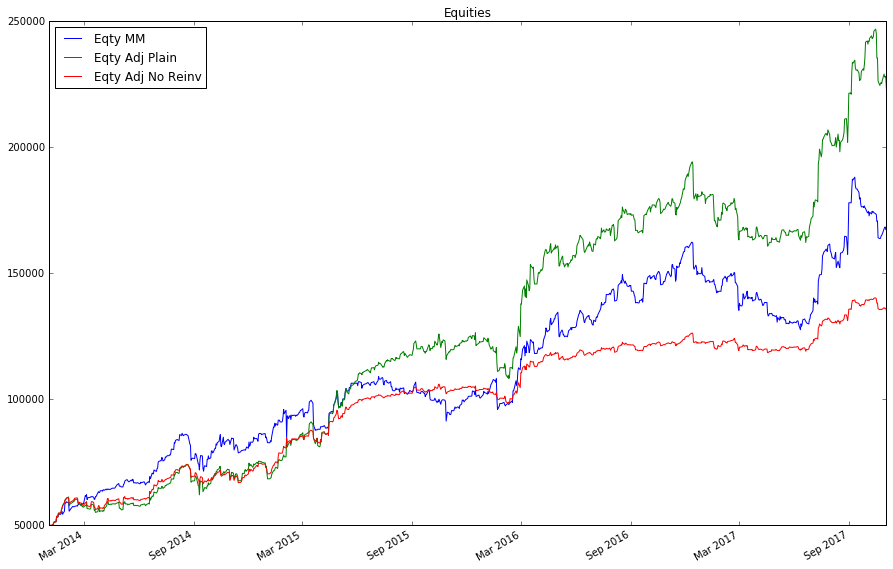

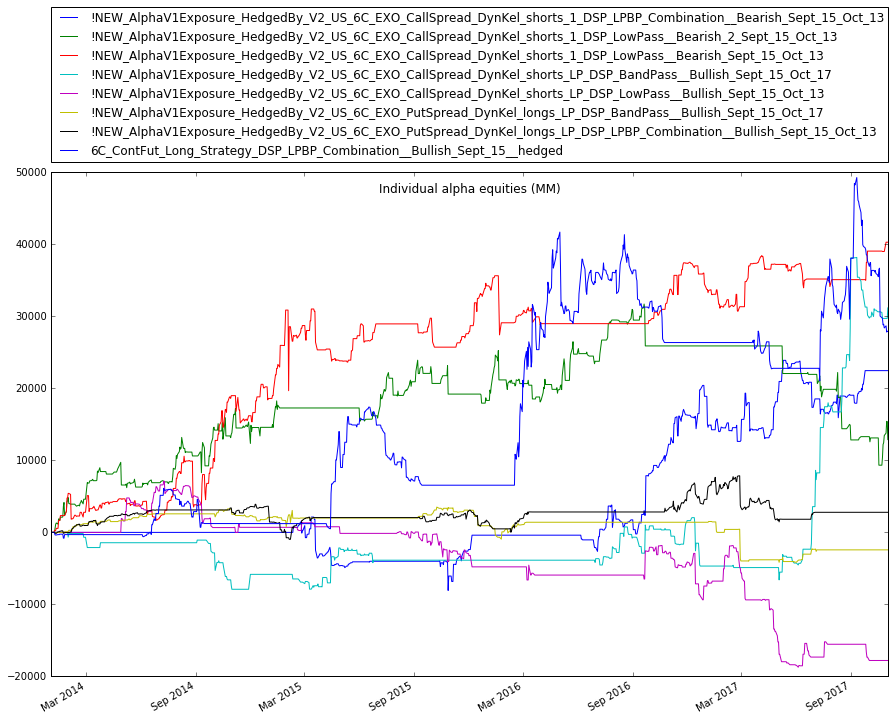

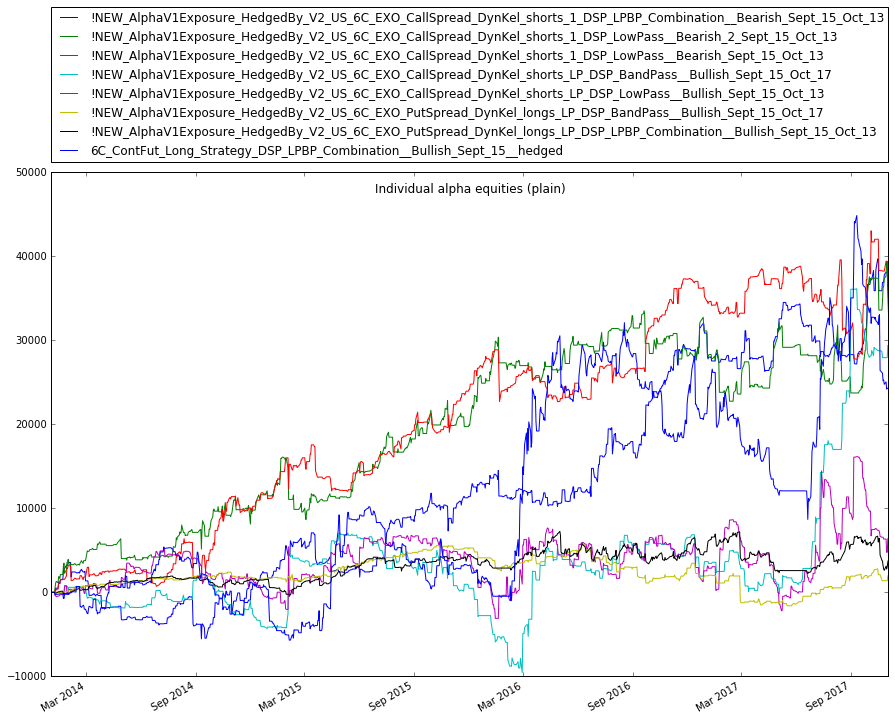

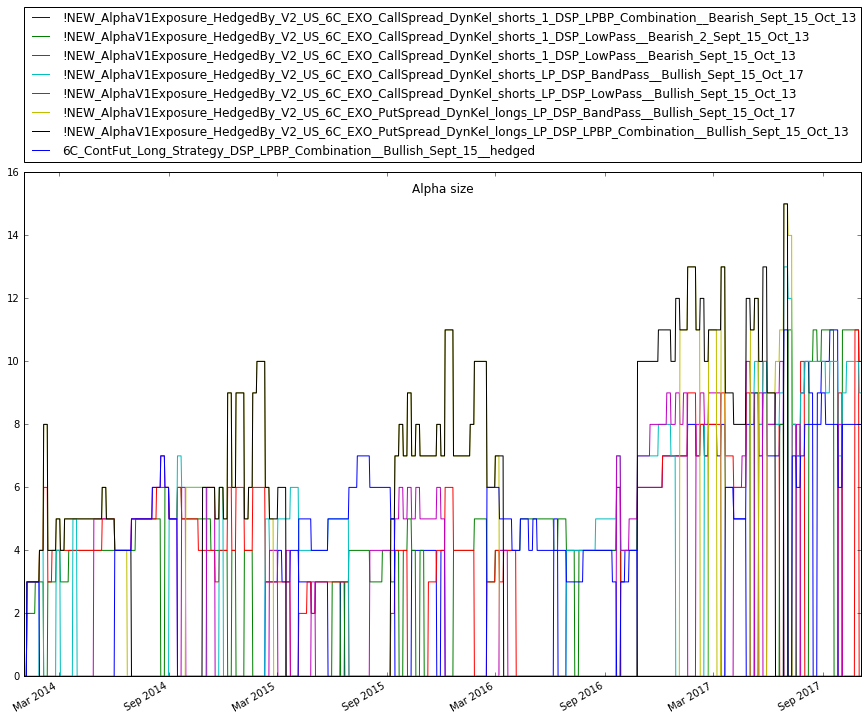

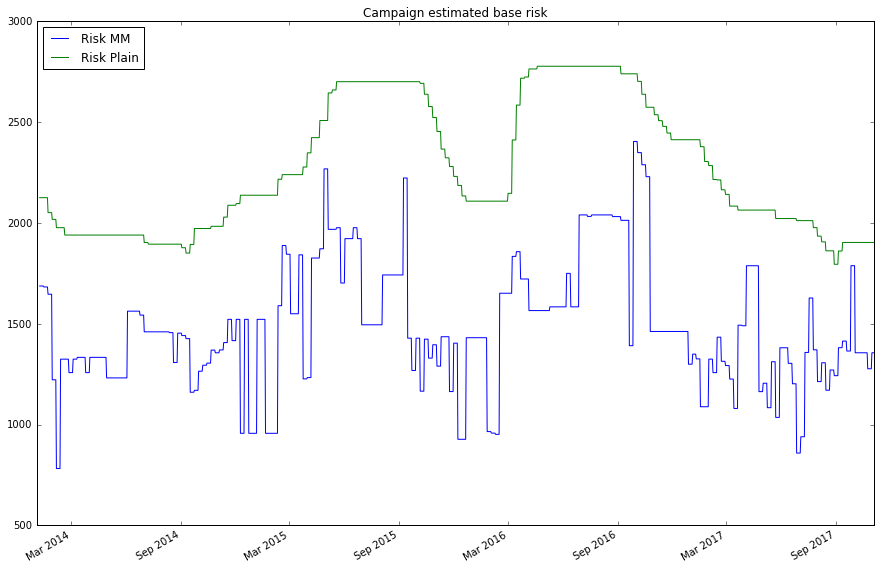

In [10]:
figsize(15, 10)
scmp.report(bt_dict)